# Part II - Classification Task

## Pen-Based Recognition of Handwritten Digits Data Set

It is a simple and well-known image bank for image recognition. It consists of 8-by-8-pixel gray-scale images divided into 10 classes of digits. And we want to solve it as a classification task using supervised learning methods.

## Setup

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm, offsetbox
import plotly.graph_objects as go

from sklearn import svm, metrics, manifold, datasets, decomposition, discriminant_analysis
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import normalize

from sklearn.datasets import load_digits

## Plot methods

In [2]:
def plot_with_labels(component1, component2, title):
    x_min, x_max = np.min(component1, axis=0), np.max(component1, axis=0)
    component1 = (component1 - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(aspect='equal')
    colors = cm.rainbow(np.array(component2).astype(float) / 10)
    sc = ax.scatter(component1[:,0], component1[:,1], lw=0, s=50, c=colors)

    shown_images = np.array([[1., 1.]])
    for i in range(component1.shape[0]):
        if np.min(np.sum((component1[i] - shown_images) ** 2, axis=1)) < 1e-2: continue
        shown_images = np.r_[shown_images, [component1[i]]]
        ax.add_artist(offsetbox.AnnotationBbox(offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), component1[i]))

    plt.xticks([]), plt.yticks([])
    plt.title(title)

## Loading dataset from sklearn

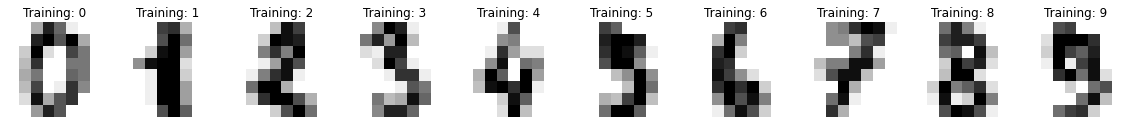

In [3]:
digits = load_digits()

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

### Normalizing and splitting dataset

In [4]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

data_normalized = normalize(data, norm='max')

training_set, test_set, training_target, test_target = train_test_split(data_normalized, digits.target, test_size=0.1, shuffle=False)

## t-SNE visualization (T-distributed stochastic neighbor embedding)

`t-SNE` is used to visualize high dimensional data. It uses a gaussian kernel to convert high dimentional elements into conection probabilities and a t-Student kernel represents conection probabilities between low dimentional elements, at a mapped space. We can clearly visualize below the classes with respective labels.

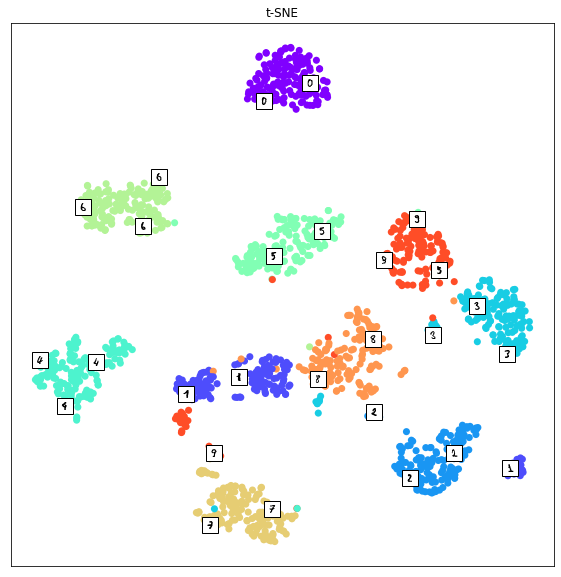

In [5]:
X_tsne = manifold.TSNE(n_components=2, init='pca').fit_transform(training_set)
plot_with_labels(X_tsne, training_target, "t-SNE")

plt.show()

## Decision Tree Classifier

Decision Trees (DTs) are a non-parametic supervised learning method used for classification and regression. In tree models, leaves represent class labels and branches represent conjunctions of features leading to the leaves (class labels). We use `DecisionTreeClassifier` from `sklearn.tree`. After using cross validation, we choose the best validation set and use it to test with the test set.

In [6]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier()

cross_validation_tree = cross_validate(clf_tree, training_set, training_target, return_estimator=True)
print(cross_validation_tree['test_score'])
print('We can observe that the split with index %d has the best score of: %0.3f.' % (np.argmax(cross_validation_tree['test_score']), cross_validation_tree['test_score'].max()))

print("From cross validation we obtain %0.3f accuracy with a standard deviation of %0.3f." % (cross_validation_tree['test_score'].mean(), cross_validation_tree['test_score'].std()))

[0.77469136 0.76234568 0.78018576 0.89783282 0.75541796]
We can observe that the split with index 3 has the best score of: 0.898.
From cross validation we obtain 0.794 accuracy with a standard deviation of 0.053.


In [7]:
cross_validation_tree['estimator'][np.argmax(cross_validation_tree['test_score'])].fit(training_set, training_target)

predicted_tree = cross_val_predict(cross_validation_tree['estimator'][np.argmax(cross_validation_tree['test_score'])], test_set, test_target)

print("Without cross validation we obtain a score of %0.3f." % (cross_validation_tree['estimator'][np.argmax(cross_validation_tree['test_score'])].score(test_set, test_target)))

Without cross validation we obtain a score of 0.822.


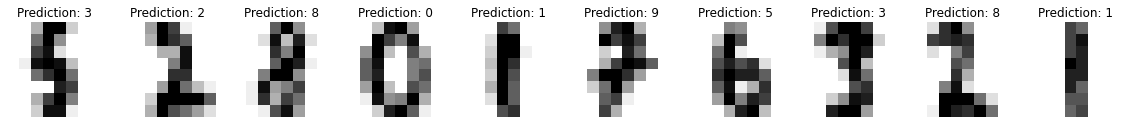

In [8]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))
for ax, image, prediction in zip(axes, test_set, predicted_tree):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction}')

We can see that the most of the 10 shown predictions are wrong. We plot the confusion matrix below to analyze better.

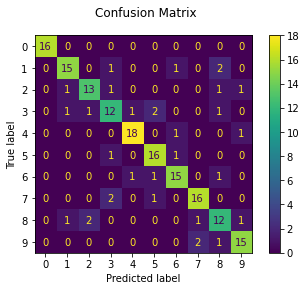

In [9]:
disp = metrics.plot_confusion_matrix(cross_validation_tree['estimator'][np.argmax(cross_validation_tree['test_score'])], test_set, test_target)
disp.figure_.suptitle("Confusion Matrix")

plt.show() 

From the confusion matrix, we can observe the number of false positive and false negative predicted labels.

## C-Support Vector Classification

Support-vector machines (SVMs) are popular supervised learning models with algorithms able to classify, analyze regression and other learning tasks. SVM usually tries to create a line or frontier that maximizes the margin between data classes. This line is called hyperplane, the distance between the hyperplane and the closest elements is the margin and the vectors that define the hyperplane are called support vectors, which give its name. 

In this project we use C-Support Vector Classification (`svm.SVC`) from sklearn lib that is based on libsvm. `C` stands for its regularization parameter, the strength of the regularization is inversely proportional to `C`. And we specify the `kernel` type to be used in the algorithm, `poly`.<br> After using cross validation, we choose the best validation set and use it to test with the test set.

In [14]:
clf_svc = svm.SVC(kernel='poly')

cross_validation_svc = cross_validate(clf_svc, training_set, training_target, return_estimator=True)
print(cross_validation_svc['test_score'])
print('We can observe that the split with index %d has the best score of: %0.3f.' % (np.argmax(cross_validation_svc['test_score']), cross_validation_svc['test_score'].max()))

print("From cross validation we obtain %0.3f accuracy with a standard deviation of %0.3f." % (cross_validation_svc['test_score'].mean(), cross_validation_svc['test_score'].std()))

[0.97839506 0.91666667 0.97832817 0.98142415 0.9504644 ]
We can observe that the split with index 3 has the best score of: 0.981.
From cross validation we obtain 0.961 accuracy with a standard deviation of 0.025.


In [11]:
cross_validation_svc['estimator'][np.argmax(cross_validation_svc['test_score'])].fit(training_set, training_target)

predicted_svc = cross_val_predict(cross_validation_svc['estimator'][np.argmax(cross_validation_svc['test_score'])], test_set, test_target)

print("Without cross validation we obtain a score of %0.3f." % (cross_validation_svc['estimator'][np.argmax(cross_validation_svc['test_score'])].score(test_set, test_target)))

Without cross validation we obtain a score of 0.967.


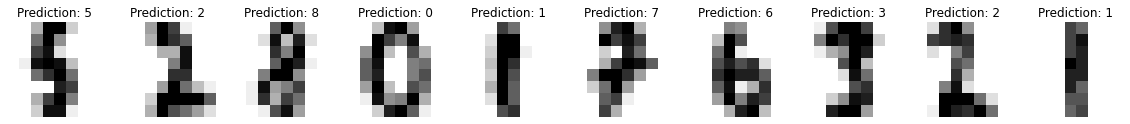

In [12]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))
for ax, image, prediction in zip(axes, test_set, predicted_svc):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction}')

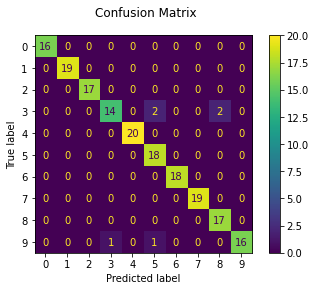

In [13]:
disp = metrics.plot_confusion_matrix(cross_validation_svc['estimator'][np.argmax(cross_validation_svc['test_score'])], test_set, test_target)
disp.figure_.suptitle("Confusion Matrix")

plt.show() 

Different from the `decision tree` plot, the predicted labels above from `SVC` are all correct and the number of false positives and false negatives in confusion matrix is a lot lower than the previous matrix. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f96ded6d-d068-4049-b80f-7d8e29514f85' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>